In [ ]:
import m2aia as m2
import numpy as np
import tensorflow as tf
from msiPL.Computational_Model import VAE_BN

import matplotlib.pyplot as plt
import os

from Example_IV_Helpers import running_variance_update as update 
from Example_IV_Helpers import running_variance_finalize as finalize
from Example_IV_Helpers import BatchSequence

from msiPL.LearnPeaks import *

from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639([1,2,3,4])

In [ ]:
from pathlib import Path

latent_dim = 5
interim_dim = 256
epochs = 50
batch_size = 128

models = None
handles = []
# READ DATA
for f in file_names:

    I = m2.ImzMLReader(f)
    I.Execute()
    handles.append(I)

vae = VAE_BN(I.GetXAxisDepth(), interim_dim, latent_dim)
myModel, encoder = vae.get_architecture()

f_name = Path(f).name
if os.path.exists(f'models/Example_IV_B_{interim_dim}_{f_name}_multiple.h5'):
    # ============= Load Model =================
    myModel.load_weights(f'models/Example_IV_B_{interim_dim}_{f_name}_multiple.h5')
else:
    # ============= Model Training =================
    dataset = m2.Dataset.SpectrumDataset(handles)
    gen = BatchSequence(dataset, batch_size=batch_size, shuffle=True)
    history = myModel.fit(gen, epochs=epochs)
    myModel.save_weights(f'models/Example_IV_B_{interim_dim}_{f_name}_multiple.h5')

models = [myModel, encoder]

In [3]:
learned_peaks = []
Beta = 1.3
for k, I in enumerate(handles):   
    I : m2.ImzMLReader = I

    count = 0
    mean = np.zeros_like(I.GetXAxis())
    deltaM2  = np.zeros_like(I.GetXAxis())
    existingAggregate = (count, mean, deltaM2)

    for i in range(I.GetNumberOfSpectra()):
        xs, ys = I.GetSpectrum(i)
        existingAggregate = update(existingAggregate, ys)
        
_, var, _ = finalize(existingAggregate)
W_enc = models[1].get_weights()
_, _, _, Real_PeakIdx = LearnPeaks(I.GetXAxis(), W_enc, np.sqrt(var), latent_dim,Beta, I.GetMeanSpectrum())
learned_peaks.append(Real_PeakIdx)


In [ ]:
mean_orig_spectra = []
mean_recon_spectra = []
for i, I in enumerate(handles):
    dataset = m2.Dataset.SpectrumDataset([I])
    gen = m2.BatchGenerator(dataset, batch_size=I.GetNumberOfSpectra(), shuffle=True)
    X = gen[0]
    R = models[0].predict(X)
    mean_orig_spectra.append(np.mean(X,axis=0))
    mean_recon_spectra.append(np.mean(R,axis=0))

In [5]:
# np.save("IV_B.np", mean_recon_spectra)
# np.save("learned_peaks", learned_peaks)

(220.0, 240.0)

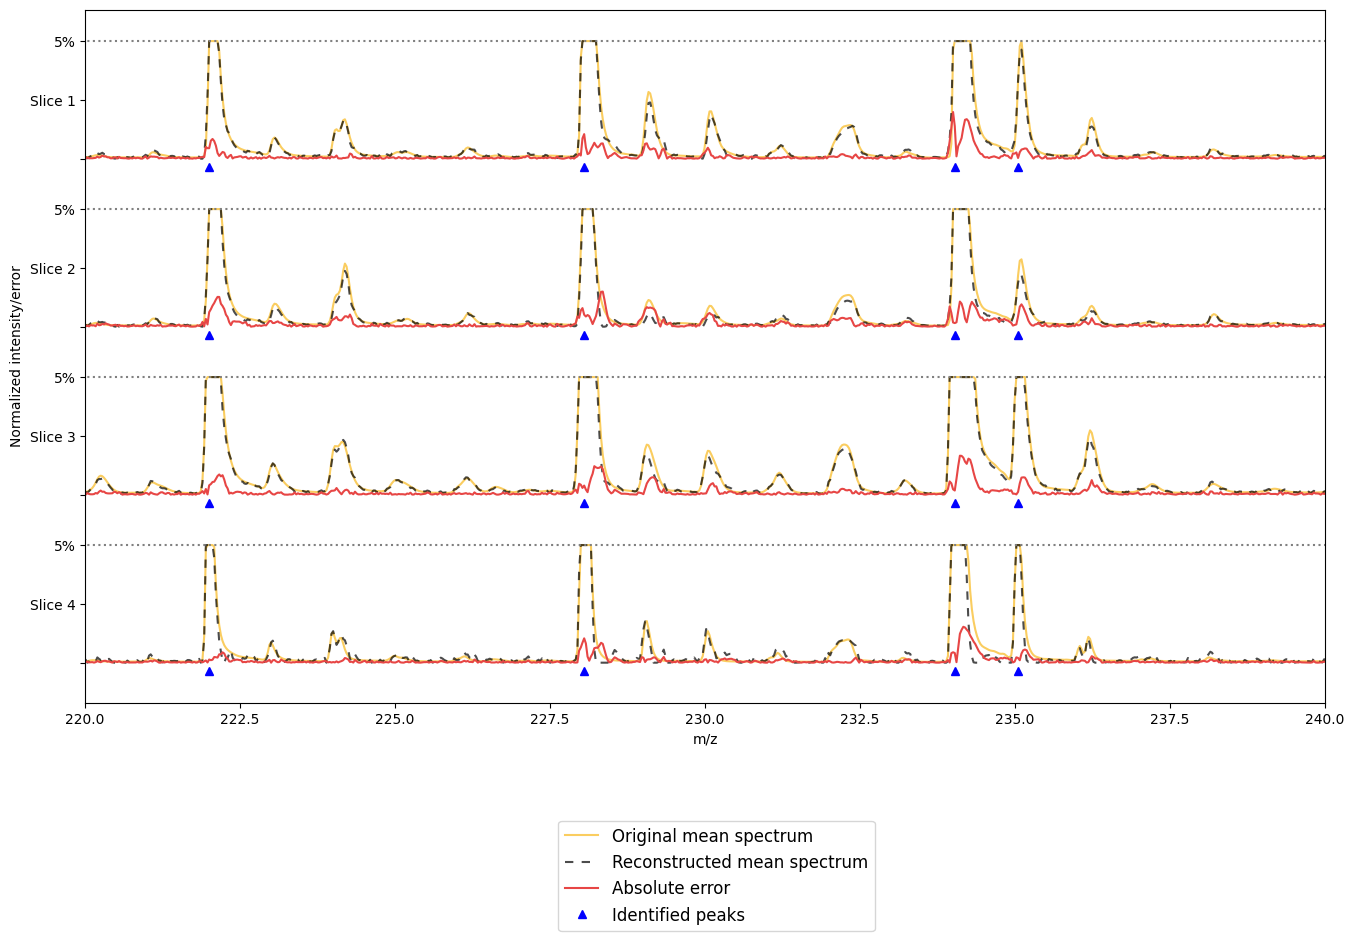

In [6]:
xs = I.GetXAxis()
colors = ['r{}','g{}','b{}','y{}']
labels = []
ytick = []
yhlines = []
ytick_label = []
scale_factor = 0.7
fraction_of_max = 0.05
stretch_factor = 1
plt.figure(figsize=(16,9))
for i, _ in enumerate(handles):
    ytick.append(-i*stretch_factor)
    yhlines.append(-i*stretch_factor-0.15)
    ytick.append(((-i*stretch_factor)+(-i*stretch_factor+scale_factor))*0.5)
    ytick.append(-i*stretch_factor+scale_factor)
    ytick_label.append('')
    ytick_label.append(f'Slice {i+1}')
    ytick_label.append(f'{int(fraction_of_max*100)}%')
    err = np.abs(mean_orig_spectra[i]-mean_recon_spectra[i])
    plt.plot(xs, np.clip(mean_orig_spectra[i]/(np.max(mean_orig_spectra[i])*fraction_of_max),0,1)*0.7 - (i*stretch_factor),  color='#facd60')
    plt.plot(xs, np.clip(mean_recon_spectra[i]/(np.max(mean_orig_spectra[i])*fraction_of_max),0,1)*0.7 - (i*stretch_factor), color='k', alpha=0.7, linestyle=(0, (4, 4)))
    plt.plot(xs, err/(np.max(mean_orig_spectra)*fraction_of_max) - (i*stretch_factor), color='#e74645')

    plt.plot(xs[learned_peaks[0]], [-(i*stretch_factor)-0.05 for _ in learned_peaks[0]], '^', color='b')

labels.append(f'Original mean spectrum')
labels.append(f'Reconstructed mean spectrum')
labels.append(f'Absolute error')
labels.append(f'Identified peaks')
plt.hlines(ytick[2::3],200,270, colors='gray', label=[f'Section {l+1}' for l in range(4)], linestyles='dotted')
plt.legend(labels=labels, fontsize='large', bbox_to_anchor=(0.375,-0.25), loc="center left")
plt.xlabel('m/z')
plt.ylabel('Normalized intensity/error')
plt.yticks(ytick, ytick_label)
plt.xlim([220, 240])

In [ ]:
# ======== Visualize encoded Features (learned non-linear spectral manifold) ==========

ims = []
height = 0
width = 0
x_dims = []
y_dims = []

for j, I in enumerate(handles):
    
    x_dim, y_dim, z_dim = I.GetShape()
    print(x_dim, y_dim, z_dim)
    im = np.zeros((latent_dim, y_dim, x_dim))
    x_dims.append(x_dim)
    y_dims.append(y_dim)

    dataset = m2.Dataset.SpectrumDataset([I])
    gen = m2.BatchGenerator(dataset, batch_size=I.GetNumberOfSpectra(), shuffle=False)
    _, _, c = models[1].predict(gen[0])
    
    for id in range(I.GetNumberOfSpectra()):
        x,y,z = I.GetSpectrumPosition(id)
        im[:, y, x] = c[id,:]
    
    # for ll in range(latent_dim):
    #     im[ll, y, x] = im[ll, y, x] - np.mean(im[ll, y, x])
    #     im[ll, y, x] = im[ll, y, x] / np.std(im[ll, y, x])
        

    ims.append(im)


<AxesSubplot:>

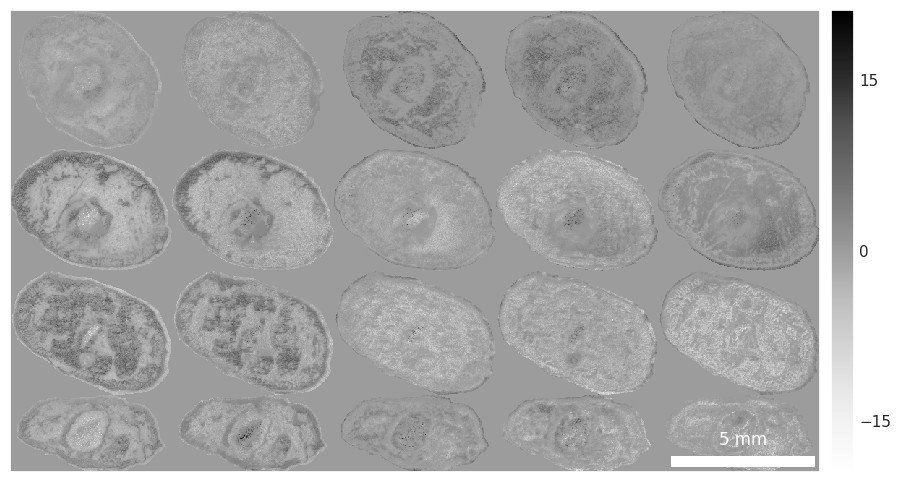

In [8]:
import seaborn as sns
import seaborn_image as seaim
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(19,6)})

height = np.sum(y_dims)
max_im_width = np.max(x_dims)
width = max_im_width * latent_dim

im_final = np.zeros((height, width))


y_pos = 0
for i, ims_temp in enumerate(ims):
    d,h,w = ims_temp.shape
    # print(h,w)
    min = np.min(ims_temp)
    max = np.max(ims_temp)
    x_pos = 0
    for k in range(latent_dim):
        # print(y_pos,y_pos+h, x_pos,x_pos+w)
        
        rescaled = np.copy(ims_temp[k])
        mask = rescaled!=0
        # rescaled[mask] = rescaled[mask] - np.mean(rescaled[mask])
        # rescaled[mask] = rescaled[mask] / np.max(np.abs(rescaled[mask]))
        w_delta_2 = (max_im_width-w)/2
        im_final[y_pos:y_pos + h , x_pos+int(w_delta_2):x_pos+int(w_delta_2)+w] = rescaled
        x_pos = x_pos + max_im_width
    y_pos = y_pos + h

# im_final[im_final!=0] = im_final[im_final!=0] - np.min(im_final)

seaim.imgplot(im_final, cmap="Greys", dx=25, units="um")
# plt.savefig("IV_B.png", dpi=350)